# 研究DJ-荔枝FM数据可视化
所有代码都已经托管在[Github](https://github.com/XiaohuiLee/lizhiFM)上，克隆仓库请用：
```
git clone https://github.com/XiaohuiLee/lizhiFM.git
```
## 1、主要库
* pandas：从csv中抽取的数据整理成DataFrame以方便数据清洗和数据操作
* numpy：数字计算util工具库
* plotly：数据可视化库

* sklearn：机器学习库
* pydotplus：决策树可视化库
* warnings：消除warnings用

## 2、摘要
通过上一步的数据爬取，我们获得了一份保存有FM频道ID，DJ，声音列表数，播放数，粉丝数，一类标签以及二类标签的原始数据。这一notebook的主要目的在于尝试借助python中的plotly库以及pydotplus，将数据更为直观地呈现出来，发现其中的有效信息；同时建立了一个简单的决策树模型用以预测DJ的影响力和粉丝数，声音列表数（努力程度）的相关性。在本文里面，我们不仅提供了可用于实际预测判断的决策树结构，还有效验证了模型在预测方面的可信度。模型在测试集上取得了大于**88.28%**的准确度。

## 3、主要步骤
* 抽取：从csv文件调用read_csv方法将所有数据加载到工作空间
* 观察：调用describe方法观察数据缺失情况以及总体分布，并针对某些主题做定量研究
* 展现：观察数据当中具有最大粉丝量，最大播放量，最大投入产出比的DJ，并呈现出来
* 机器学习：尝试利用决策树对DJ的权威值（热点程度）做相关预测，并返回训练好的决策树结构。

## 关于plotly
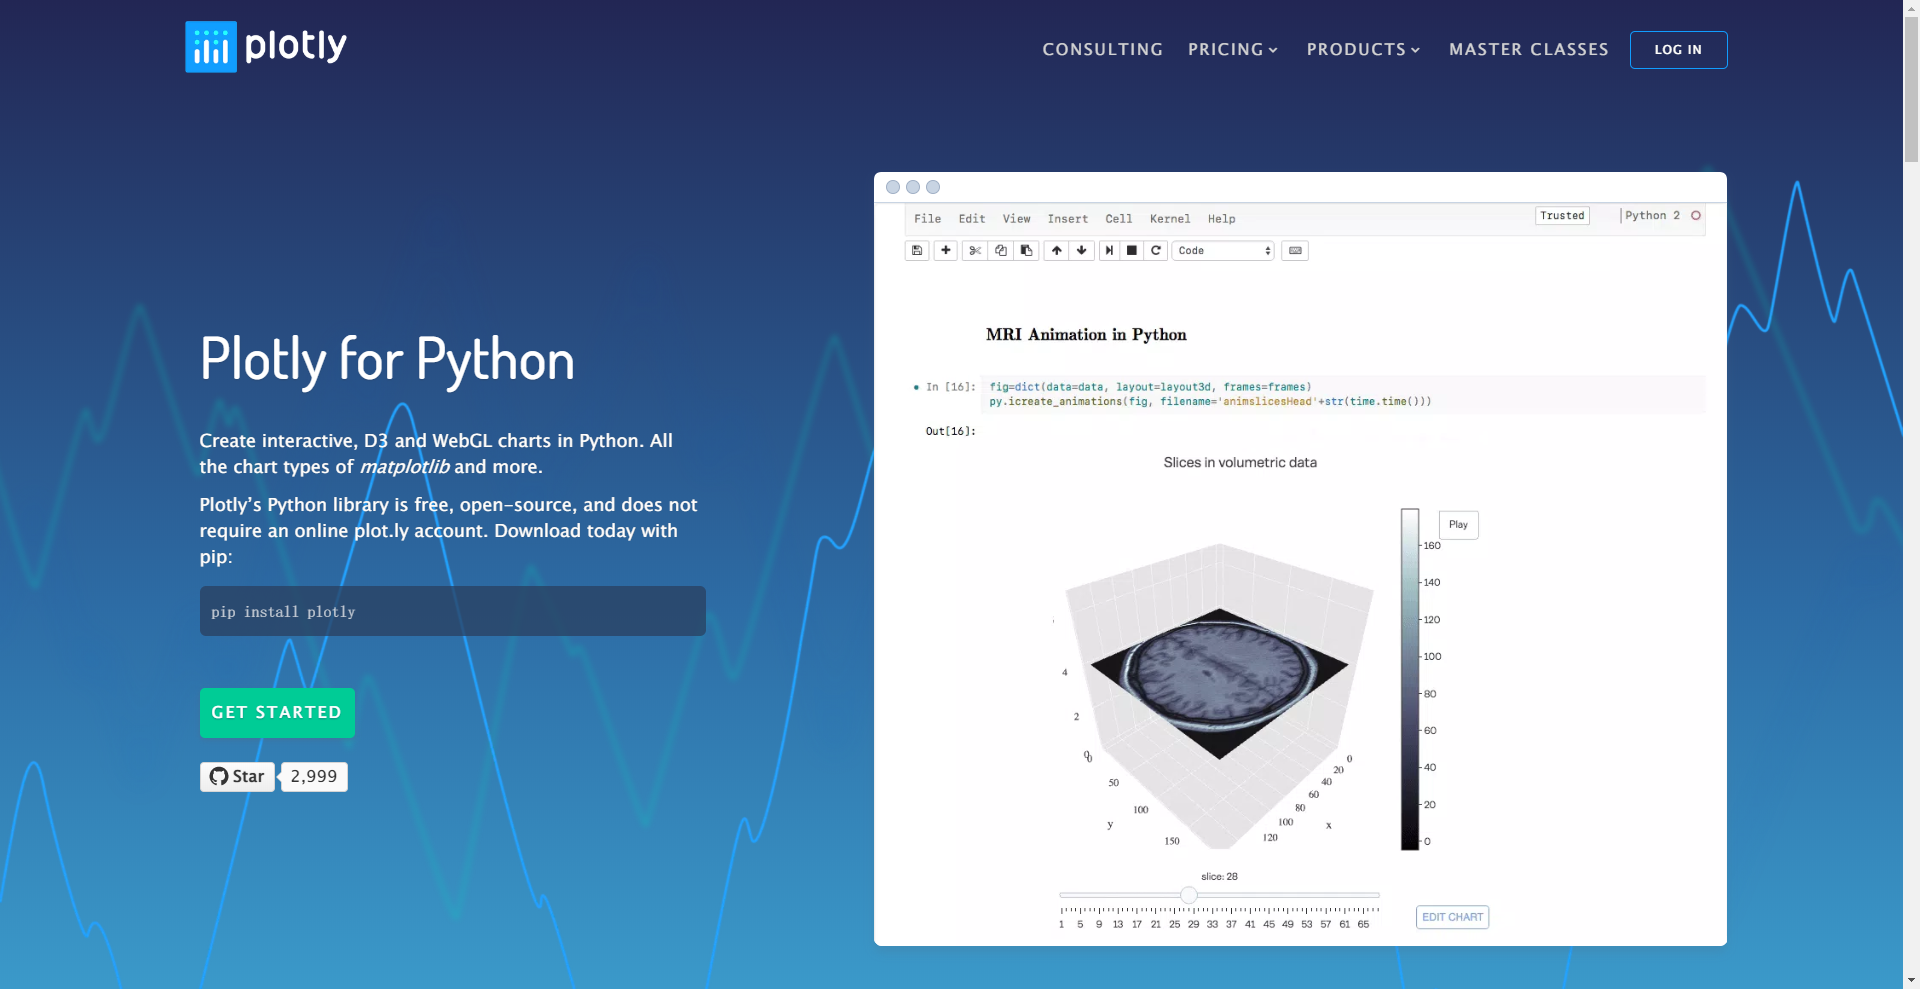
* plotly是现代平台的敏捷商业智能和数据科学库，它作为一款开源的绘图库，可以应用于Python、R、MATLAB、Excel、JavaScript和jupyter等多种语言，主要使用的js进行图形绘制，实现过程中主要就是调用plotly的函数接口，底层实现完全被隐藏，便于初学者的掌握。plotly的官方主页在[这里](https://plot.ly/d3-js-for-python-and-pandas-charts/)，github主页在[这里](https://github.com/plotly/plotly.py/)。
* 安装plotly：使用pip来安装plotly库，如果机器上没有pip，需要先进行pip的安装，这里主要介绍plotly的安装。

    On windows:
    ```bash
    pip install plotly 
    ```
    On linux
    ```bash
    sudo pip install plotly 
    ```

>plotly.py is an interactive, browser-based graphing library for Python ✨
>Built on top of plotly.js, plotly.py is a high-level, declarative charting library. plotly.js ships with over 30 chart types, including scientific charts, 3D graphs, statistical charts, SVG maps, financial charts, and more.
>plotly.py is MIT Licensed. Plotly graphs can be viewed in Jupyter notebooks, standalone HTML files, or hosted online on plot.ly.

In [2]:
# 2018年1月28日20:44:43
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
from IPython.display import Image  

from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske
from sklearn.externals.six import StringIO  

from sklearn.tree import export_graphviz
import pydotplus

py.init_notebook_mode() 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 从csv文件中加载数据到dataDf中
dataDf = pd.read_csv('FM.CSV', header=-1)#由于read_csv默认从第二行开始读取数据，而我们保存的FM.csv中没有行头，所以需要将header置为-1
dataDf.columns = ['FM', 'Author', 'Radios', 'Plays', 'Fans', 'label1', 'label2']
print(dataDf.head())

        FM     Author  Radios        Plays       Fans label1 label2
0   193491       DJ程一     828  485570000.0  1748000.0     情感     治愈
1    18084  背着吉他的蝙蝠女侠     441  328480000.0  2648000.0     情感     治愈
2   681575     蕊希Erin     277   51620000.0   547000.0     情感     治愈
3  1455354  园长妈妈的睡前故事     913   52230000.0    58000.0     亲子     童话
4    67590       DJ陈末     459   93690000.0  1168000.0     情感     治愈


In [4]:
# 描述数据
print(dataDf.describe())

                 FM        Radios         Plays          Fans
count  5.000000e+02    500.000000  5.000000e+02  5.000000e+02
mean   1.143862e+07    358.630000  8.738026e+06  3.044808e+05
std    2.354080e+07    834.140954  3.080995e+07  4.475957e+06
min    1.043400e+04      1.000000  2.600000e+01  3.800000e+01
25%    7.403760e+05     19.000000  1.390000e+05  2.410500e+03
50%    1.594941e+06    109.500000  1.027000e+06  1.100000e+04
75%    3.274018e+06    355.500000  5.738750e+06  5.350000e+04
max    9.820649e+07  10484.000000  4.855700e+08  1.000000e+08


从输出结果可以看出，对于热榜中的FM频道，有__50%__的DJ声音列表数在105.5（106）之上，有**25%**的DJ声音列表数在__349__首之上;

而对于播放量，最小值去到**175**次，而最大值去到**4亿8千万**次，两极分化十分严重，从分位数可以看出，__75%__的DJ播放量在__5百万__以下，呈现出严重的长尾分布；

这点在粉丝数上也表现出相同的规律，最大值去到**一亿**粉丝量，而有75%的DJ粉丝量在**5万**以下。

单从现有数据上看，热榜当中的DJ表现出寡头DJ占有了大部分播放量以及粉丝，可能的原因是用户粘性不足，大多数新用户偏向于收听荔枝大V的声音列表，对于其他DJ的播放量和粉丝量没有做出太大贡献。

In [5]:
# 获取拥有最多（少）播放量以及最多（少）粉丝量的DJ
print(dataDf[dataDf.Plays == max(dataDf.Plays)])
print(dataDf[dataDf.Plays == min(dataDf.Plays)])
print(dataDf[dataDf.Fans == max(dataDf.Fans)])
print(dataDf[dataDf.Fans == min(dataDf.Fans)])

       FM Author  Radios        Plays       Fans label1 label2
0  193491   DJ程一     828  485570000.0  1748000.0     情感     治愈
           FM        Author  Radios  Plays   Fans label1 label2
409  76203598  荳芽🐾［花火Radio］       1   26.0  845.0      空      空
        FM Author  Radios        Plays         Fans label1 label2
301  12345    荔枝妹     144  118760000.0  100000000.0     娱乐     访谈
           FM Author  Radios   Plays  Fans label1 label2
386  96073705   小阿晴吖      31  5084.0  38.0      空      空


In [157]:
# barPlot(x, y, title, intendent)
# 作用：柱状图函数
# 参数：
#     x：x轴
#     y：y轴
#     title：图表标题
# intendent：ticklabel缩进
# 返回值：
#     无
def barPlot(x, y, title, intendent):
    da = go.Bar(
        y = x,
        x = sorted(y,reverse=True),
        marker=dict(
            color='rgb(200,202,225)',
            line=dict(
                color='rgb(8,48,107)',
                width=1.5,
            )
        ),
        opacity=0.6,
        hoverlabel=dict(
            font = dict(
                size = 12
            )    
        ),
        orientation = 'h',
    )
    layout = go.Layout(
        title= title,
        titlefont = dict(
            size = 24
        )
    )
    annotations = []
    for xi, yi in zip(x, y):
    # labeling the scatter savings
        annotations.append(dict(
                                y=xi, x=yi + intendent,
                                text='{:,}'.format(int(yi)),
                                font=dict(family='Arial', size=12,
                                          color='rgb(128, 0, 128)'),
                                showarrow=False))
        # labeling the bar net worth
    
    layout['annotations'] = annotations
    fig = go.Figure(data = [da], layout = layout)
    py.iplot(fig)

In [158]:
# 筛选出播放量top 20的DJ
top20Plays = dataDf.sort_values('Plays', ascending=False)[:20]
print(top20Plays)

          FM      Author  Radios        Plays         Fans label1 label2  \
0     193491        DJ程一     828  485570000.0    1748000.0     情感     治愈   
1      18084   背着吉他的蝙蝠女侠     441  328480000.0    2648000.0     情感     治愈   
14    415593    睡不醒的莹莹主播     287  140630000.0    1118000.0     情感     治愈   
183   233233      闪闪、徐好玩     225  121820000.0    2904000.0    脱口秀    段子手   
301    12345         荔枝妹     144  118760000.0  100000000.0     娱乐     访谈   
4      67590        DJ陈末     459   93690000.0    1168000.0     情感     治愈   
6      13461        糖蒜广播    1884   88330000.0     716000.0    脱口秀    名嘴秀   
135    70098         饶雪漫     320   83490000.0     934000.0     情感     美文   
17     21243    爱读童书妈妈小莉    1608   82910000.0     140000.0     亲子     伴读   
224   496737        蚊子xi     125   79470000.0     723000.0     音乐     流行   
11    353471    十点读书官方播客     879   77400000.0     551000.0     情感     美文   
283    17952          宿雨     217   75230000.0     541000.0     情感     治愈   
147   403783

In [160]:
barPlot(top20Plays.Author, top20Plays.Plays, '播放量最高的20位DJ', 30000000)

In [142]:
# 筛选出声音列表数量top 10的DJ
top20Radios = dataDf.sort_values('Radios', ascending=False)[:20]
print(top20Radios)

          FM         Author  Radios       Plays      Fans label1 label2  \
246  1039061         GNEHC夕   10484   9871000.0   36000.0    二次元     古风   
86   3193225          诗宝的蝎子    8779    721000.0    2010.0     音乐     翻唱   
7    1289380            幽默学    4663  31150000.0   55000.0     文化     人文   
275  1464597  Dear_Baekhyun    4658  20040000.0   88000.0    二次元     古风   
40    231563          老虎工作室    4629  55190000.0   95000.0     亲子     伴读   
91   3721564         单田芳评书😃    4046   1214000.0    2254.0     文化    有声书   
46   1715672         Arios🎶    3190   5341000.0  155000.0    广播剧     纯爱   
198  1970438    Miss_zhang张    3098   4247000.0   17000.0    广播剧     纯爱   
33    413301      老刺猬（87Fm）    2592  10560000.0   28000.0     文化     惊悚   
132  1421862          一只小楘七    2477    651000.0    3764.0    二次元     古风   
41   1251230           体坛先锋    2370  17480000.0   59000.0     语言     粤语   
162  1587413           睡前伴读    2167   1561000.0    5151.0     情感     治愈   
120   682742         草精灵故

In [164]:
barPlot(top20Radios.Author, top20Radios.Radios, '产出最高的20位DJ', 500)

In [76]:
# 筛选出粉丝量top 20的DJ
top20Fans = dataDf.sort_values('Fans', ascending=False)[:20]
print(top20Fans)

          FM         Author  Radios        Plays         Fans label1 label2  \
301    12345            荔枝妹     144  118760000.0  100000000.0     娱乐     访谈   
183   233233         闪闪、徐好玩     225  121820000.0    2904000.0    脱口秀    段子手   
1      18084      背着吉他的蝙蝠女侠     441  328480000.0    2648000.0     情感     治愈   
0     193491           DJ程一     828  485570000.0    1748000.0     情感     治愈   
241    10520      卢思浩Kevin.     129   33830000.0    1297000.0     情感     治愈   
112   116090          作家马家辉     222   65660000.0    1283000.0     文化     人文   
195  1776072       读心女神安安老师     250   42010000.0    1245000.0     情感     心理   
4      67590           DJ陈末     459   93690000.0    1168000.0     情感     治愈   
14    415593       睡不醒的莹莹主播     287  140630000.0    1118000.0     情感     治愈   
200   187702           NJ苏木     190   22610000.0    1090000.0     情感     治愈   
465  1499789           欧阳应霁     152   45430000.0    1089000.0     文化     人文   
135    70098            饶雪漫     320   83490000.0    

In [168]:
barPlot(top20Fans.Author, top20Fans.Fans, '粉丝最多的20位DJ', 5000000)

图形里显示荔枝妹是拥有粉丝最多的DJ，我就很好奇荔枝妹是谁，去主页里看了发现原来是荔枝的官方DJ，尝试从数据里剔除掉荔枝妹后得到real真实的数据如下：

In [174]:
Rtop20Fans = dataDf.sort_values('Fans', ascending=False)[1:21]
barPlot(Rtop20Fans.Author, Rtop20Fans.Fans, '粉丝最多的20位DJ', 150000)

闪闪、徐好玩又是哪位？去主页看了一下，嗯是相声哈哈哈哈哈哈哈哈，看来荔枝er喜欢相声小品的也不少啊。

对于这些DJ，我们比较好奇的是作品数和播放量粉丝量之间有没有关系，投入作品少的人是不是播放量和粉丝量就会相对性少；单首作品能为DJ带来多少播放量和粉丝，在这里我们定义：`投入产出比 = (播放量 + 粉丝数) / 作品数`，表示单位作品数产出的贡献，我们来看看投入产出比最高的Top 20 DJ。

In [49]:
dataDf['Roe'] = np.divide(np.add(dataDf.Plays, dataDf.Fans), dataDf.Radios)
print(dataDf.head())

        FM     Author  Radios        Plays       Fans label1 label2  \
0   193491       DJ程一     828  485570000.0  1748000.0     情感     治愈   
1    18084  背着吉他的蝙蝠女侠     441  328480000.0  2648000.0     情感     治愈   
2   681575     蕊希Erin     277   51620000.0   547000.0     情感     治愈   
3  1455354  园长妈妈的睡前故事     913   52230000.0    58000.0     亲子     童话   
4    67590       DJ陈末     459   93690000.0  1168000.0     情感     治愈   

             Roe    Authority  
0  588548.309179  146545165.6  
1  750857.142857   99868088.2  
2  188328.519856   15759555.4  
3   57270.536692   15698182.6  
4  206662.309368   28691091.8  


In [50]:
# 筛选出投入产出比top 20的DJ
top20Roe = dataDf.sort_values('Roe', ascending=False)[:20]
print(top20Roe)

           FM     Author  Radios        Plays         Fans label1 label2  \
42   87713823        胡一天       5   20980000.0     480000.0      空      空   
237   1252048   张皓宸Orson      10   25080000.0      24000.0     娱乐     偶像   
351    198754        李易峰       3    6184000.0     538000.0     娱乐     偶像   
301     12345        荔枝妹     144  118760000.0  100000000.0     娱乐     访谈   
31     660618  艾辰吖🍊泡泡冠名√      16   15630000.0     641000.0    二次元     古风   
81    3190279       Boss      17   12520000.0     523000.0     音乐     翻唱   
1       18084  背着吉他的蝙蝠女侠     441  328480000.0    2648000.0     情感     治愈   
141  48134057     Vin周震南       1     708000.0      13000.0      空      空   
128   2776579    尊尊🙂ASMR      27   17760000.0      40000.0     情感     治愈   
224    496737       蚊子xi     125   79470000.0     723000.0     音乐     流行   
0      193491       DJ程一     828  485570000.0    1748000.0     情感     治愈   
183    233233     闪闪、徐好玩     225  121820000.0    2904000.0    脱口秀    段子手   
18   4703955

In [178]:
barPlot(top20Roe.Author, top20Roe.Roe, '投入产出比最高的20位DJ', 200000)

我们尝试用唯一指标衡量dj的影响力，不妨称之为为权威值，权威值的计算公式如下:
    `权威值 = 0.5 * 粉丝量 + 0.3 * 播放量 + 0.2 * 作品量`
我们尝试研究不同DJ的影响力分布。

In [56]:
dataDf['Authority'] = 0.5 * dataDf.Fans + 0.3 * dataDf.Plays + 0.2 * dataDf.Radios
top20Authority = dataDf.sort_values('Authority', ascending= False)
print(dataDf.head())

        FM     Author  Radios        Plays       Fans label1 label2  \
0   193491       DJ程一     828  485570000.0  1748000.0     情感     治愈   
1    18084  背着吉他的蝙蝠女侠     441  328480000.0  2648000.0     情感     治愈   
2   681575     蕊希Erin     277   51620000.0   547000.0     情感     治愈   
3  1455354  园长妈妈的睡前故事     913   52230000.0    58000.0     亲子     童话   
4    67590       DJ陈末     459   93690000.0  1168000.0     情感     治愈   

             Roe    Authority  
0  588548.309179  146545165.6  
1  750857.142857   99868088.2  
2  188328.519856   15759555.4  
3   57270.536692   15698182.6  
4  206662.309368   28691091.8  


In [53]:
da = go.Scatter(
    x = dataDf.Author,
#     取10为底的对数
    y = sorted(np.log10(dataDf.Authority),reverse=True),
#     y = np.log10(dataDf.Authority),
#     y = dataDf.Authority,
    mode = 'markers',
    marker = dict(
        color = 'rgb(0,22,225)',
    ),
    opacity=0.6,
    hoverlabel=dict(
        font = dict(
            size = 12
        )    
    ) 
)
layout = go.Layout(
    title= "DJ权威值分布情况 By DJ",
    titlefont = dict(
        size = 24
    )
)
fig = go.Figure(data = [da], layout = layout)
py.iplot(fig)

上述是从DJ的维度观察数据，我们尝试从另一个角度——`DJ归属类别`来看看我们的数据

In [18]:
# 筛选出标签不为空的数据
dataDf_noEmpLabels = dataDf[(dataDf['label1'] != '空') & (dataDf['label2'] != '空')]

In [19]:
# 观察标签不为空的数据里面的归属大类和归属小类
label1s = dataDf_noEmpLabels['label1'].value_counts()
label2s = dataDf_noEmpLabels['label2'].value_counts()
print(label1s, label2s)

情感     127
音乐      56
亲子      52
脱口秀     37
文化      35
二次元     34
广播剧     29
娱乐      16
语言      14
生活      10
资讯       3
Name: label1, dtype: int64 治愈       77
童话       30
翻唱       23
美文       23
流行       22
神吐槽      15
有声书      14
恋爱       13
古风       13
名嘴秀      12
育儿       12
宅文化      12
伴读       10
纯爱       10
人文        9
现代剧       9
英语交流      8
偶像        8
惊悚        7
心理        7
CV        7
私房话       7
纯音乐       6
影视        5
段子手       5
达人秀       5
民谣        5
粤语        4
同人        4
电台        4
诗歌        3
古风剧       3
综艺        2
ACG音乐     2
历史        2
游戏        2
公益        2
财经        2
女性        2
动漫        1
影视英语      1
旅行        1
健康        1
其他        1
访谈        1
体育        1
Name: label2, dtype: int64


不出意外的，情感类的FM是最多的；而在二类标签里面，治愈也是最多的（治愈属于情感的二类标签），看起来FM用户整体喜好偏向于情感抒发和共鸣，喜欢蓝调忧伤（不知道悲伤的人别听慢歌吗这群忧伤的年轻人啊哈哈哈哈哈哈），无怪乎咪蒙能被称之为鸡汤女王。荔枝FM的用户整体偏向年轻，也更容易对悲天悯人谈情说爱之类的DJ产生好感；

值得注意的是，二类标签里第二名是童话标签，我大致扫看了一下原始数据，发现有许多温馨的麻麻级别DJ，比如大地园长妈妈、爱讲故事的园长妈妈、园长妈妈的睡前故事，还有乐音堂童话家族、微小宝睡前童话故事等，提供了童话标签排名第二的支撑。即便没有用户数据，我们也可以猜测，荔枝FM用户里也有不少80后麻麻。

In [20]:
# 依据归属大类聚合数据
datadf1 = dataDf_noEmpLabels.groupby('label1').aggregate('sum')
print(datadf1.head())

               FM  Radios         Plays         Fans           Roe  \
label1                                                               
二次元      53819842   23001  1.590512e+08    2943903.0  2.681887e+06   
亲子      124203001   31305  4.130102e+08     883275.0  8.920707e+05   
娱乐       21740094    1863  1.992530e+08  101218857.0  7.023152e+06   
广播剧     104494531   13199  5.402973e+07     656983.0  3.470486e+05   
情感      518053108   30869  2.147561e+09   25202966.0  6.908346e+06   

          Authority  
label1               
二次元      49191920.4  
亲子      124350963.0  
娱乐      110385702.6  
广播剧      16540049.7  
情感      656875826.6  


In [21]:
# piePlot(x, y, title = None)
# 作用：饼状图函数
# 参数：
#     x：x轴
#     y：y轴
#     title：图表标题
# 返回值：
#     无
def piePlot(x, y, title=None):
    da = go.Pie(
        labels=x, 
        values=y
    )
    layout = go.Layout(
        title= title,
        titlefont = dict(
            size = 24
        )
        
    )
    fig = go.Figure(data = [da], layout = layout)
    py.iplot(fig)

In [22]:
piePlot(datadf1.index, datadf1['Authority'], "DJ权威值分布情况 By 大类")

情感类的热门DJ果然是最多的。音乐，亲子，脱口秀，娱乐主打轻松休闲的DJ获得了第二梯队的位置，而其他的类别则显得要凋零一些，缺乏有力的支撑。

In [23]:
# 合并大类标签和小类标签
try:
    dataDf_noEmpLabels['label'] = dataDf_noEmpLabels['label1'] + "-" +dataDf_noEmpLabels['label2']
except e:
    print(e)
print(dataDf_noEmpLabels.head())

        FM     Author  Radios        Plays       Fans label1 label2  \
0   193491       DJ程一     828  485570000.0  1748000.0     情感     治愈   
1    18084  背着吉他的蝙蝠女侠     441  328480000.0  2648000.0     情感     治愈   
2   681575     蕊希Erin     277   51620000.0   547000.0     情感     治愈   
3  1455354  园长妈妈的睡前故事     913   52230000.0    58000.0     亲子     童话   
4    67590       DJ陈末     459   93690000.0  1168000.0     情感     治愈   

             Roe    Authority  label  
0  588548.309179  146545165.6  情感-治愈  
1  750857.142857   99868088.2  情感-治愈  
2  188328.519856   15759555.4  情感-治愈  
3   57270.536692   15698182.6  亲子-童话  
4  206662.309368   28691091.8  情感-治愈  


In [24]:
# 按照合并后的标签聚合数据
datadf2 = dataDf_noEmpLabels.groupby('label').aggregate('sum')
print(datadf2.head())

                 FM  Radios       Plays       Fans           Roe   Authority
label                                                                       
二次元-ACG音乐   4228334      76   8135000.0    69000.0  2.332338e+05   2475015.2
二次元-动漫      1092276      52    792000.0    15000.0  1.551923e+04    245110.4
二次元-古风     22088455   19851  74155229.0  1674922.0  1.731972e+06  23087999.9
二次元-同人      7945991     744  14043000.0   509000.0  3.044164e+05   4467548.8
二次元-宅文化    16418336    1367  41395000.0   461268.0  3.622347e+05  12649407.4


In [25]:
piePlot(datadf2.index, datadf2['Authority'], "DJ权威值分布情况 By 所有类别")

情感-治愈一类轻松获得了最高的位置，显示出用户喜好的单一，属于明显的单边喜好；其他类别基本上都较为均匀，在整体喜好中所占份额没有情感-治愈那么显著。

我们尝试引入机器学习的决策树算法，尝试对DJ的影响力做出预测。可以尝试用来解决的问题包括：
* 假如我想成为热门DJ里的20%，我应该可以从哪些方面入手？
* 假如我是FM中的DJ，我是否可以算是FM中影响力人物？

我们定义热门DJ里按权威值排序的前20%位DJ为较成功的DJ，标记为1；剩余80%的DJ标记为0。由于建立以一个决策树要求数据集所有变量为整型或者浮动型，我们还需要对数据集进行文字到整型的映射。
测试集和训练集由sklearn自动划分。

In [26]:
# generate_target(df)
# 作用：给df的每条记录打标签，这个标签将作为决策树训练时的目标类别
# 参数：
#     df：待处理的df（包含FM频道，DJ，声音列表数等等，其中Authority值是必须的）
# 返回：
#     打完标签的df
def generate_target(df):
    dataBak = df.copy()
    dataBak['Target'] = pd.Series(np.zeros(dataBak.shape[0]))
    splitIndex = np.floor(dataBak.shape[0] * .2)
    dataBak =  dataBak.sort_values('Authority', ascending = False)
    dataBak['Target'][:int(splitIndex)] = "1"
    dataBak['Target'][int(splitIndex):] = "0"
    return(dataBak)

In [27]:
# preprocess_df(df)
# 作用：将文本（字符串）映射到数值变量
# 参数：
#     df：待处理的df
# 返回：
#     处理后的df
def preprocess_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.label1 = le.fit_transform(processed_df.label1)
    processed_df.label2 = le.fit_transform(processed_df.label2)
#     processed_df.embarked = le.fit_transform(processed_df.embarked.factorize()[0])
    processed_df = processed_df.drop(['FM','Roe', 'Author', 'label'],axis=1)
    return processed_df

In [35]:
# 给去除了空标签值后的DataFrame打标签并映射大类和二类标签
dataBak = generate_target(dataDf_noEmpLabels)
print(dataBak['Target'].value_counts())
processed = preprocess_df(dataBak)
print(processed.head())

0    331
1     82
Name: Target, dtype: int64
     Radios        Plays         Fans  label1  label2    Authority Target
0       828  485570000.0    1748000.0       4      26  146545165.6      1
1       441  328480000.0    2648000.0       4      26   99868088.2      1
301     144  118760000.0  100000000.0       2      42   85628028.8      1
14      287  140630000.0    1118000.0       4      26   42748057.4      1
183     225  121820000.0    2904000.0       7      24   37998045.0      1


有82位DJ被标记为1,331位DJ被标记为0.Label1和Label2（大类标签和二类标签）也已经映射到整型了，我们现在来看看如何拆分数据集。

In [36]:
# 拆分DataFrame，分为输入数据x和输出（目标）数据y
# 选择输入数据
select_columns = ['Radios','Fans','label1', 'label2']
x = processed.filter(items=select_columns)
# 选择输出数据
y = processed.filter(items = ['Target'])
# 划分训练集和测试集
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size = 0.2)

In [37]:
# 定义分类器决策树并拟合数据
classifer = tree.DecisionTreeClassifier(max_depth=5)
classifer.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
# 预测
classifer.predict(xtest)

array(['0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0'], dtype=object)

In [39]:
# 预测精度区间
classifer.predict_proba(xtest)

array([[ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.22222222,  0.77777778],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.5       ,  0.5       ],
       [ 0.22222222,  0.77777778],
       [ 0.22222222,  0.77777778],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,

In [40]:
# 分类器的得分
classifer.score(xtest, ytest)

0.90361445783132532

可以看出，模型取得了90.36%的准确率，整体预测效果是很不错的。我们尝试将决策树结构画出来看看。

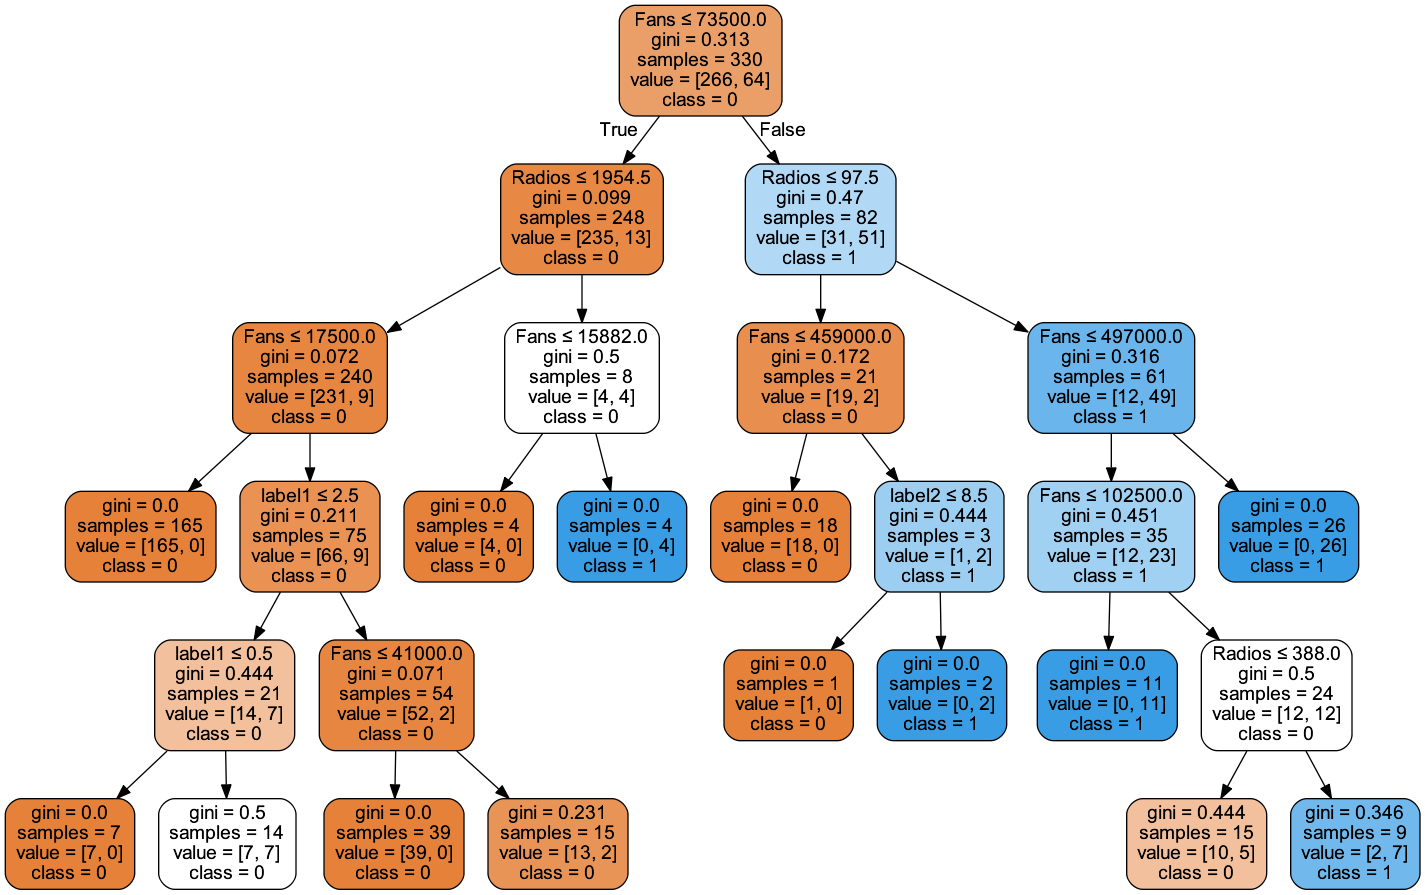

In [41]:
# 可视化决策树结构
dot_data = StringIO()
export_graphviz(classifer, out_file=dot_data,  
                feature_names = x.columns,
                class_names = ['0','1'],
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

由上面的决策树模型可以看出来，对DJ具有决定性影响的应该是粉丝数量，其次是声音列表数量。举个例子，假如一个DJ粉丝数在102500到497000之间并且声音列表数大于388，我们可以认为该DJ应当属于较有影响力的DJ之一。

我们尝试交换训练集和测试集里的数据，重新测试一下分类器。交换次数20次，测试集大小设定为全体数据的38.2%，输出分类器的得分均值以及得分方差。

In [42]:
# shuffle数据集求得分均值以及方差
shuffle_validator = cross_validation.ShuffleSplit(len(x), n_iter=20, test_size=0.382, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, x, y.values.ravel(), cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [40]:
# 求普通决策树分类器的得分
test_classifier(classifer)

Accuracy: 0.9215 (+/- 0.02)


In [43]:
# 随机森林模型
randomForestClf = ske.RandomForestClassifier(n_estimators=100)
test_classifier(randomForestClf)

Accuracy: 0.8981 (+/- 0.02)


In [42]:
# ET树模型
etClf = ske.ExtraTreesClassifier(n_estimators=100)
test_classifier(etClf)

Accuracy: 0.9480 (+/- 0.01)


In [43]:
# Bagging方法
baClf = ske.BaggingClassifier(n_estimators=100)
test_classifier(baClf)

Accuracy: 0.9523 (+/- 0.02)


In [44]:
# 梯度Boosting方法
gbClf = ske.GradientBoostingClassifier(n_estimators=100)
test_classifier(gbClf)

Accuracy: 0.9495 (+/- 0.01)


In [45]:
# AdaBoosting方法
abClf = ske.AdaBoostClassifier(n_estimators=100)
test_classifier(abClf)

Accuracy: 0.9337 (+/- 0.02)


In [46]:
# 集成诸多分类器,选取预测效果最好的分类器(Ensemble过程)
eclf = ske.VotingClassifier([('dt', classifer), ('rf', randomForestClf), ('gb', gbClf),('et', etClf), ('ba', baClf)])
test_classifier(eclf)

Accuracy: 0.9514 (+/- 0.01)


# 总结：
我们通过对抓取的数据进行简单地可视化，发现了荔枝FM热榜发现里最具影响力的TOP 20 DJ；并运用了决策树模型结合Ensemble方法，给出了判定DJ是否是影响力人物的判定规则，整体模型准确率在__89.81% ~ 95.14%__之间，模型总体而言是令人满意的。


In [59]:
最具影响力的TOP 20 DJ
# print(top20Authority[:20])

         FM      Author  Radios        Plays         Fans label1 label2  \
0    193491        DJ程一     828  485570000.0    1748000.0     情感     治愈   
1     18084   背着吉他的蝙蝠女侠     441  328480000.0    2648000.0     情感     治愈   
301   12345         荔枝妹     144  118760000.0  100000000.0     娱乐     访谈   
14   415593    睡不醒的莹莹主播     287  140630000.0    1118000.0     情感     治愈   
183  233233      闪闪、徐好玩     225  121820000.0    2904000.0    脱口秀    段子手   
4     67590        DJ陈末     459   93690000.0    1168000.0     情感     治愈   
6     13461        糖蒜广播    1884   88330000.0     716000.0    脱口秀    名嘴秀   
135   70098         饶雪漫     320   83490000.0     934000.0     情感     美文   
17    21243    爱读童书妈妈小莉    1608   82910000.0     140000.0     亲子     伴读   
224  496737        蚊子xi     125   79470000.0     723000.0     音乐     流行   
11   353471    十点读书官方播客     879   77400000.0     551000.0     情感     美文   
283   17952          宿雨     217   75230000.0     541000.0     情感     治愈   
147  403783     ECHO任小珺  